# 1. Initial settings

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import time,os
import xarray as xr
import pickle
from scipy import stats
# import pytables
plt.rcParams.update({'font.size': 16})
################################
# import oggm and Get the default params
from oggm import cfg, utils, workflow, tasks, graphics
import oggm.cfg as cfg
cfg.initialize(logging_level='warning')
cfg.PARAMS['cfl_number'] = 0.01  # less numerical instabilities
cfg.PARAMS['use_multiprocessing'] = False
from oggm.core.massbalance import ScalarMassBalance
from oggm.core.flowline import FluxBasedModel,fa_sermeq_speed_law,k_calving_law
# from oggm.tests.funcs import bu_tidewater_bed
#no_mb = ScalarMassBalance()
mb_model = ScalarMassBalance()

################################
# import idealized bed topography function based on the Bassis & Ultee bed profile
import Idealized_Bed_Topography
from Idealized_Bed_Topography import bu_tidewater_bed
################################
#setting the workplace
rgi_id = 'Idealized_bed (bu)_new'
Figpath='/home/ruitang/Astra_Ruitang_UIO/Frontal_Ablation_Global/New_Results/Idealized_Bubed_Tests_Sermeq'
# figure
Figpath_Folder_tif_path=Figpath+'/Tif/'+rgi_id+'/'
Figpath_Folder_png_path=Figpath+'/Png/'+rgi_id+'/'
Figpath_Folder_tif=utils.mkdir(Figpath_Folder_tif_path,reset=True)
Figpath_Folder_png=utils.mkdir(Figpath_Folder_png_path,reset=True)
# data
Figpath_Folder_data_path=Figpath+'/Data/'+rgi_id+'/'
Figpath_Folder_data=utils.mkdir(Figpath_Folder_data_path,reset=True)
file_txt_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.txt'
#with open(file_txt_path_name,"w") as file:
#    file.write("************* Here is the model results ************* \n")
file_data_path_name=Figpath_Folder_data_path+rgi_id+'_Modelresults.pickle'

2023-12-22 11:58:40: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-12-22 11:58:40: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-12-22 11:58:40: oggm.cfg: Multiprocessing: using all available processors (N=8)
2023-12-22 11:58:40: oggm.cfg: PARAMS['cfl_number'] changed from `0.02` to `0.01`.


In [8]:

from oggm.utils import show_versions
show_versions()

'# OGGM environment: \n## System info:\n    python: 3.8.17.final.0\n    python-bits: 64\n    OS: Linux\n    OS-release: 5.11.0-27-generic\n    machine: x86_64\n    processor: x86_64\n## Packages info:\n    oggm: 1.6.1.dev58+g1f6e75c.d20231207\n    numpy: 1.23.2\n    scipy: 1.10.1\n    pandas: 1.5.3\n    geopandas: 0.13.2\n    netCDF4: 1.6.4\n    matplotlib: 3.7.2\n    rasterio: 1.3.7\n    fiona: 1.9.4\n    pyproj: 3.5.0\n    shapely: 2.0.1\n    xarray: 2023.1.0\n    dask: 2023.5.0\n    salem: 0.0.0\n    OGGM git identifier: 96a9b56c4bacef12dcbbd25f0bdde8b32696c612'

In [9]:
import sys
print(sys.path)

['/home/ruitang/Astra_Ruitang_UIO/oggm_Ruitang/oggm/FA_Sermeq_R&L', '/home/ruitang/miniconda3/envs/pygem_env/lib/python38.zip', '/home/ruitang/miniconda3/envs/pygem_env/lib/python3.8', '/home/ruitang/miniconda3/envs/pygem_env/lib/python3.8/lib-dynload', '', '/home/ruitang/miniconda3/envs/pygem_env/lib/python3.8/site-packages']


# 2. Test on an idealized profile
## 2.1 Bu bed topography


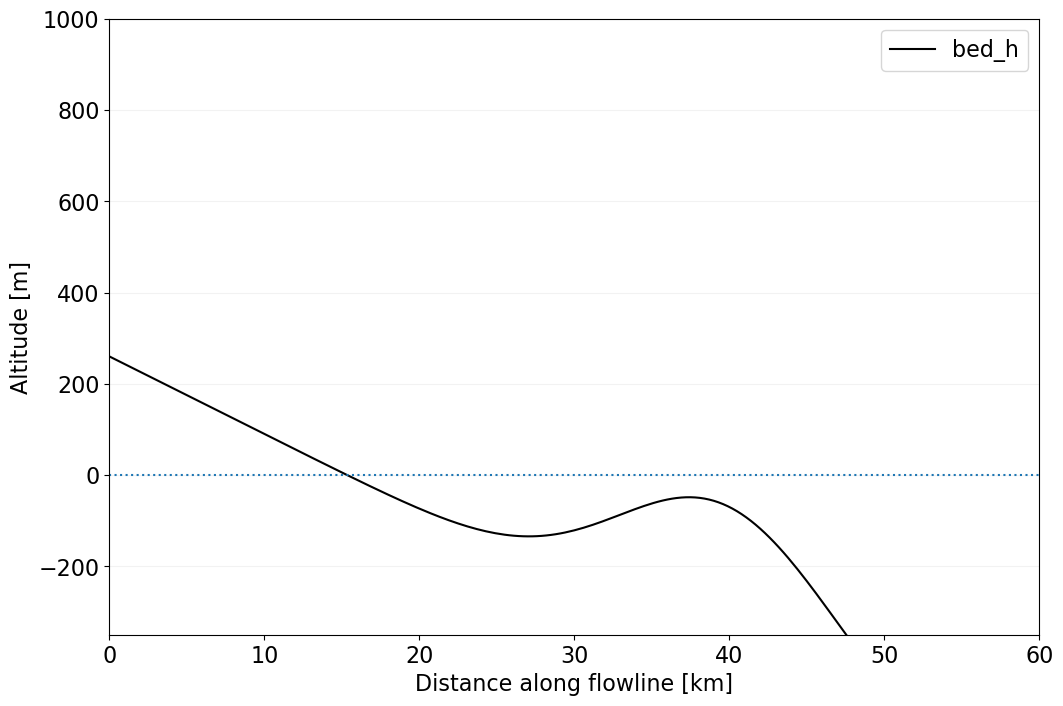

In [10]:
# import the idealized bed, BU from Lizz
bu_fl = bu_tidewater_bed()[0]
xc = bu_fl.dis_on_line * bu_fl.dx_meter / 1000
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(xc, bu_fl.bed_h, color='k',label='bed_h')
# ax.plot(xc, bu_fl.surface_h, color='b',label='surface_h') #surface_h=bed_h
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.xlim(*xc[[0, -1]]); plt.ylim(-350, 1000); plt.ylabel('Altitude [m]');
plt.xlabel('Distance along flowline [km]');
plt.grid(axis='y', color='0.95')
plt.legend();
#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Glacier_bed_profile'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Glacier_bed_profile'+'.png',dpi=600,bbox_inches='tight')

## 2.2 Put a k-calving profile on top of this and check what viscoplastic calving rates we'd get


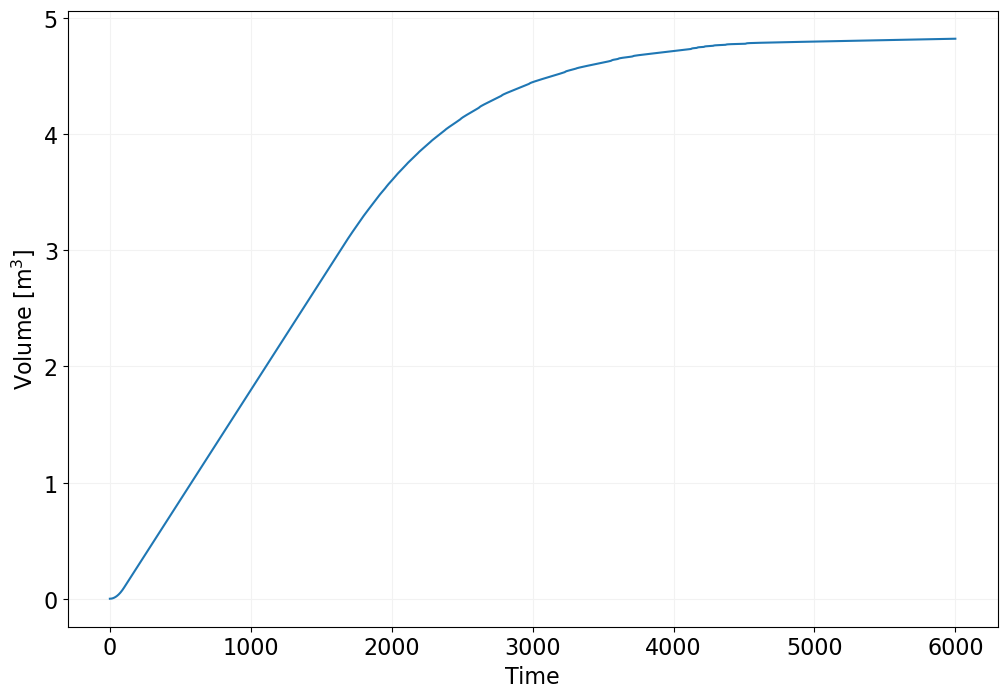

In [11]:
model = FluxBasedModel(bu_fl, mb_model=mb_model,
                       is_tidewater=True,
                       calving_use_limiter=True,  # default is True
                       flux_gate=0.06,  # default is 0
                       calving_k=0.2,  # default is 2.4
                       do_kcalving=True,
                       calving_law=k_calving_law,
                      )
# long enough to reach approx. equilibrium
ds = model.run_until_and_store(6000)
df_diag = model.get_diagnostics()

# save the k-calving results in the dataset
my_data_output={'k-calving_m3a_TimeSeri':ds.calving_m3,'k-calving_rate_ma_TimeSeri':ds.calving_rate_myr,'k-calving_myr_Mean':model.calving_rate_myr}
# print the k-calving rate
with open(file_txt_path_name,"a") as file:
    print('--------------- K-Calving results ---------------',file=file)
    print('The averaged k-calving rate over the 6000 years is {:.2f} m per year, '
      '\n and {:.2f} m3 per year \n'.format(model.calving_rate_myr,model.calving_m3_since_y0/6000),file=file)
## TODO: save the data in a picklds file


# check the timeseries of volume (same to the calving and calving rate, use ds.calving_m3, calving_rate_myr)
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax=(ds.volume_m3*1e-9).plot()
plt.ylabel('Volume [m$^{3}$]')
plt.xlabel('Time')
plt.grid(axis='y', color='0.95')
plt.grid(axis='x', color='0.95')
#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Volume_change_Timeseries'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Volume_change_Timeseries'+'.png',dpi=600,bbox_inches='tight')

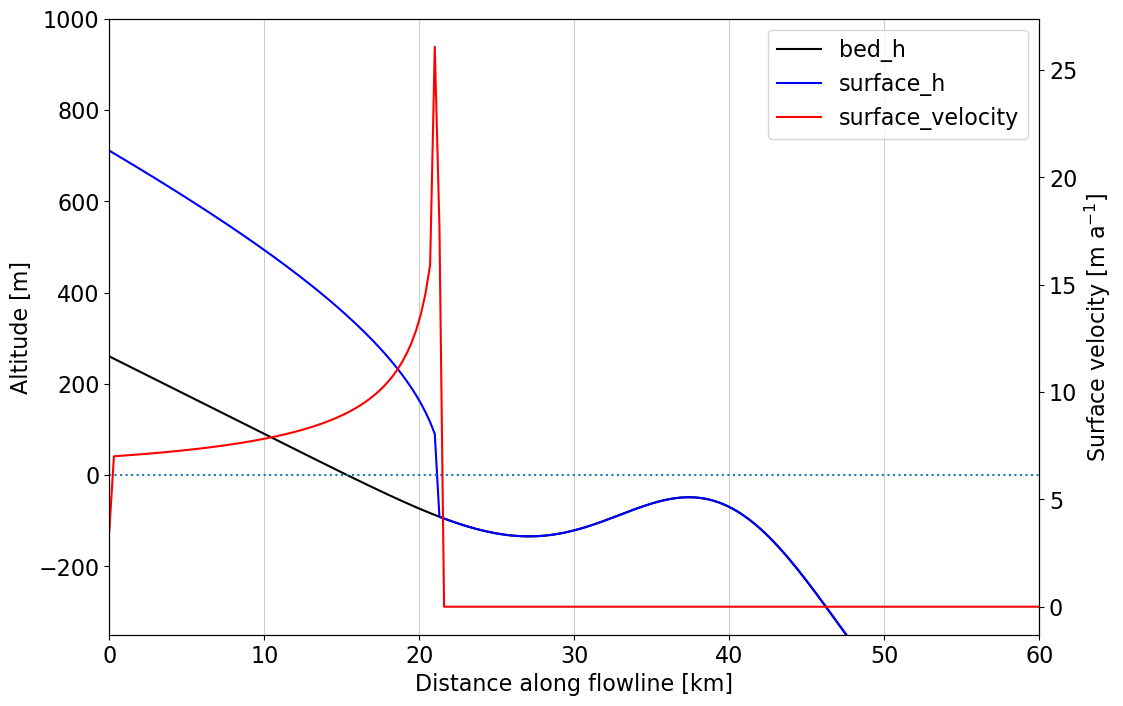

In [12]:
# the Bu-bed in SERMeq, bed_h
plt.figure(1,figsize=(12, 8))
# plt.subplot(2,1,1)
# lns1,=plt.plot(xc, bu_fl.bed_h, color='k',label='bed_h')
# plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
# plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Altitude [m]')
# plt.grid(axis='x', color='0.8')
# plt.legend()
# the k-calving result, surface_h
ax1=plt.subplot(1,1,1)
lns2,=ax1.plot(xc, df_diag.bed_h, color='k',label='bed_h')
lns3,=ax1.plot(xc, df_diag.surface_h, color='b',label='surface_h')
plt.hlines(0, *xc[[0, -1]], color='C0', linestyles=':')
plt.xlim(0, 60);plt.ylim(-350, 1000); plt.ylabel('Altitude [m]');plt.xlabel('Distance along flowline [km]')
plt.grid(axis='x', color='0.8')
ax2=ax1.twinx()
lns4,=ax2.plot(xc, df_diag.ice_velocity*31536000, color='r',label='surface_velocity')
plt.ylabel('Surface velocity [m a$^{-1}$]')
legend_profile=plt.legend(handles=[lns2,lns3,lns4],loc='upper right')

#save the figure
# plt.savefig(Figpath_Folder_tif_path+rgi_id+'Ideal_bed_kcalving_profile_with_volotcity'+'.tif',dpi=600,bbox_inches='tight')
# plt.savefig(Figpath_Folder_png_path+rgi_id+'Ideal_bed_kcalving_profile_with_volotcity'+'.png',dpi=600,bbox_inches='tight')

## 2.3 Frontal_ablation_Sermeq_Speed

In [14]:
######################prepare the input data
surface_profile = df_diag.surface_h
bed_profile = df_diag.bed_h
x = df_diag.index
model_U = df_diag.ice_velocity * cfg.SEC_IN_YEAR ## convert ice velocity to m/a
with open(file_txt_path_name,"a") as file:
    print('the maximum velocity is {:.2f}'.format(max(model_U)),file=file)
# Find index of the terminus
term_index = int(np.argwhere(surface_profile.values>0)[-1])
print(term_index)
input_profile = (x.values[:term_index+1], ## slice up to index+1 to include the last nonzero value
                 surface_profile.values[:term_index+1],
                 bed_profile.values[:term_index+1])
input_velocity = model_U.values[:term_index+1]

# save the mass balance data on the flowline
my_data_output['Surface massblance ma']=mb_model.get_annual_mb(heights=surface_profile.values)

with open(file_txt_path_name,"a") as file:
    print('the mean surface mass balance along the flowline is {:.2f}\n'.format(np.mean(mb_model.get_annual_mb(heights=surface_profile.values))),file=file)

## TODO: check this is surface mass balance or whole mass balance?

###################### do the Sermeq fa calculation
# call the fa_from_velocity function to calculation the frontal ablation
SQFA =fa_sermeq_speed_law(profile=input_profile,
            model_velocity=input_velocity, v_scaling=1, Terminus_mb=0,verbose=True,tau0=150e3, yield_type='constant', mu=0.01)

#SQFA is a dictionary, including se_terminus','bed_terminus','Thickness_termi','Hy_thickness','Velocity_termi','dLdt','Sermeq_fa'

# save the data
my_data_output['Sermeq frontal ablation ma']= SQFA
# with open(file_data_path_name,'wb')as file:
#     pickle.dump(my_data_output,file)

with open(file_txt_path_name,"a") as file:
    print('--------------- Sermeq results ---------------',file=file)
    print('the terminus mass balance is {:.2f} m per year\n'.format(SQFA['Terminus_mb']),file=file)
    print('the terminus velocity is {:.2f} m per year\n'.format(SQFA['Velocity_termi']),file=file)
    print('the Sermeq length change rate is {:.2f} m per year\n'.format(SQFA['dLdt']),file=file)
    # print('the Sermeq frontal ablation is {:.2f} m per year\n'.format(mb_model.get_annual_mb(heights=surface_profile.values)),file=file)



70


TypeError: fa_sermeq_speed_law() got an unexpected keyword argument 'profile'

# 3. Sensitive tests of yield strength, terminus surface mass balance, ice speed scaling